# Load modules and data

In [1]:
#  Importing the main library for building model and its analysis
import xgboost as xgb
import seaborn as sns 
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, classification_report
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split
from sklearn.datasets import make_classification

In [2]:
# Import Python  print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

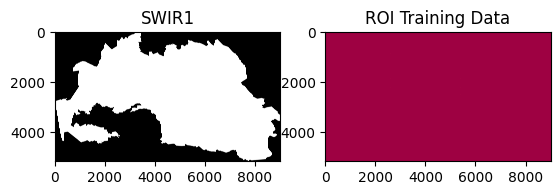

In [3]:
# Read in our image and ROI image
img_ds = gdal.Open('../Final_results/clip_united_2020.tif', gdal.GA_ReadOnly)
"""
This data collection includes the bands of sensors from Sentinel-2 satellite constellations: 
B2 - blue (wavelength centre of electromagnetic radiation on satellite A: 492 nm), 
B3 - green (560 nm), B4 - red (665 nm), B8 - near-infrared (NIR: 833 nm), B11 – far infrared-1 (SWIR-1: 1614 nm), 
B12 – far infrared-2 (SWIR-2: 2202 nm), and calculated vegetation indices: NDVI, NDWI, NBR 
and the difference between NBR 2019 and 2020 (attached to the 2020 data list); 
as well as added Sentinel-1 radar channels with polarization: VH, VV and the simple ratio between VV and VH (VV / VH).
"""

roi_ds = gdal.Open('../Final_results/final_train_sample_2020.tif', gdal.GA_ReadOnly)
"""
Identified landscape types in the formed training sample: 0 – water body, 1 – area without vegetation,
2 – meadow or fallow, 3 – swamp, 4 – single or groups of bushes and trees, 5 – forest, 6 – a deaded stand after fire damage, 7 – deaded stand without the influence of the pyrogenic factor
"""

# Copy the transformation to a variable
GT_input = img_ds.GetGeoTransform()

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

# Clean up RAM
img_ds = ""
roi_ds = ""


# Prepocessing of input data

In [4]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0]
y_interm = roi[roi > 0]
y = y_interm-1

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 2210 samples
The training data include 8 classes: [1 2 3 4 5 6 7 8]
Our X matrix is sized: (2210, 13)
Our y array is sized: (2210,)


In [5]:
# Convert data from array to pd dataframe

import pandas as pd

X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [6]:
# Columns in "X" data collections
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.0181,0.0378,0.0239,0.3056,0.1408,0.0621,0.854932,-0.767025,0.652976,-15.272573,-9.763872,0.639308,0.048605
1,0.0203,0.0376,0.0307,0.1896,0.1166,0.0579,0.721289,-0.630883,0.454031,-14.167418,-8.873853,0.626356,0.164594
2,0.0173,0.0373,0.0225,0.2456,0.1408,0.0636,0.832152,-0.776263,0.636779,-16.750376,-9.430263,0.562988,0.051821
3,0.0145,0.0283,0.0206,0.2210,0.1365,0.0594,0.829470,-0.786016,0.644311,-15.324182,-8.929756,0.582723,-0.016151
4,0.0201,0.0383,0.0284,0.2242,0.1470,0.0700,0.775139,-0.715976,0.550802,-14.043212,-11.585570,0.824994,0.025033


In [7]:
# Columns in "y" data collections
y.head()

,0
0,5
1,5
2,5
3,5
4,5


# Create first XGBoost model for estimate varibiality of output stats

In [8]:
# K-Folds cross-validation for estimation "quality" of input data for building model
X_kfold = pd.DataFrame(X).to_numpy()
y_kfold = pd.DataFrame(y).to_numpy()

In [9]:
# Function for comparing datasets on homogeneity 
def display_scores(scores):
    print("    Scores: {0}\n    Mean: {1:.3f}\n    Std: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [10]:
# Output results of K-Folds cross-validation for XGBoost model
kfold = KFold(n_splits=5, shuffle=True)
scores = []
for train_index, test_index in kfold.split(X_kfold):   
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]

    xgb_model = xgb.XGBClassifier(objective="multi:softprob", eval_metric=['mlogloss'])
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
      
    scores.append(accuracy_score(y_test, y_pred))
    
print('Accuracy classification score: \n')
display_scores(scores)
print('\n', 20*'-')

Accuracy classification score: 

    Scores: [0.8212669683257918, 0.8167420814479638, 0.8438914027149321, 0.8280542986425339, 0.8461538461538461]
    Mean: 0.831
    Std: 0.012

 --------------------


# Add optimal hyperparameters for XGBoost model

In [11]:
# Overwrite hyperparameters data for the next step/stage
p1 = 0.46263769780760494     # colsample_bytree
print('Colsample_bytree: ' + str(p1))

p2 = 0.4076530193693614                # gamma
print('Gamma: ' + str(p2))

p3 = 0.05713257641708951        # learning_rate
print('Learning_rate: ' + str(p3))

p4 = 6            # max_depth
print('Max_depth: ' + str(p4))

p5 = 77         # n_estimators
print('N_estimators: ' + str(p5))

p6 = 0.3601252948102243            # subsample
print('Subsample: ' + str(p6))

Colsample_bytree: 0.46263769780760494
Gamma: 0.4076530193693614
Learning_rate: 0.05713257641708951
Max_depth: 6
N_estimators: 77
Subsample: 0.3601252948102243


# Creating a basic XGBoost model for est. of uncertainties

In [12]:
# Create DMatrix (is an internal data structure) 
data_dmatrix = xgb.DMatrix(data=X,label=y)


 Iteration #1 

[0]	validation_0-mlogloss:1.93071	validation_1-mlogloss:1.93464
[1]	validation_0-mlogloss:1.80161	validation_1-mlogloss:1.80842
[2]	validation_0-mlogloss:1.69451	validation_1-mlogloss:1.70499
[3]	validation_0-mlogloss:1.59928	validation_1-mlogloss:1.61339
[4]	validation_0-mlogloss:1.51236	validation_1-mlogloss:1.53020
[5]	validation_0-mlogloss:1.43386	validation_1-mlogloss:1.45509
[6]	validation_0-mlogloss:1.36508	validation_1-mlogloss:1.38983
[7]	validation_0-mlogloss:1.30153	validation_1-mlogloss:1.33027
[8]	validation_0-mlogloss:1.24523	validation_1-mlogloss:1.27617
[9]	validation_0-mlogloss:1.19138	validation_1-mlogloss:1.22598
[10]	validation_0-mlogloss:1.14426	validation_1-mlogloss:1.18258
[11]	validation_0-mlogloss:1.09709	validation_1-mlogloss:1.13794
[12]	validation_0-mlogloss:1.05332	validation_1-mlogloss:1.09797
[13]	validation_0-mlogloss:1.01390	validation_1-mlogloss:1.06384
[14]	validation_0-mlogloss:0.97761	validation_1-mlogloss:1.03048
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


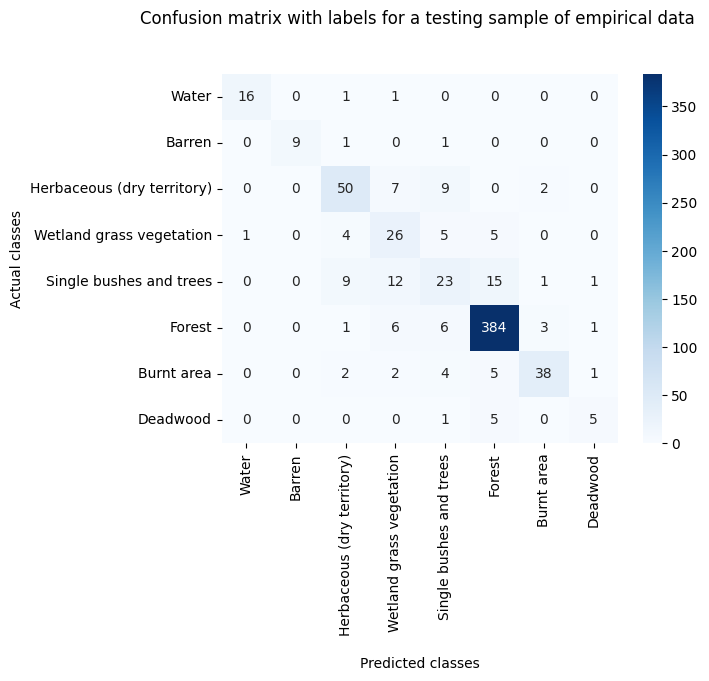

<Figure size 3000x3000 with 0 Axes>


 Iteration #2 

[0]	validation_0-mlogloss:1.93026	validation_1-mlogloss:1.94282
[1]	validation_0-mlogloss:1.79897	validation_1-mlogloss:1.82071
[2]	validation_0-mlogloss:1.69233	validation_1-mlogloss:1.72329
[3]	validation_0-mlogloss:1.59428	validation_1-mlogloss:1.63362
[4]	validation_0-mlogloss:1.50908	validation_1-mlogloss:1.55604
[5]	validation_0-mlogloss:1.42994	validation_1-mlogloss:1.48610
[6]	validation_0-mlogloss:1.35966	validation_1-mlogloss:1.42245
[7]	validation_0-mlogloss:1.29431	validation_1-mlogloss:1.36382
[8]	validation_0-mlogloss:1.23395	validation_1-mlogloss:1.31086
[9]	validation_0-mlogloss:1.18019	validation_1-mlogloss:1.26500
[10]	validation_0-mlogloss:1.13166	validation_1-mlogloss:1.22184
[11]	validation_0-mlogloss:1.08506	validation_1-mlogloss:1.18129
[12]	validation_0-mlogloss:1.04228	validation_1-mlogloss:1.14559
[13]	validation_0-mlogloss:1.00356	validation_1-mlogloss:1.11375
[14]	validation_0-mlogloss:0.96522	validation_1-mlogloss:1.08180
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


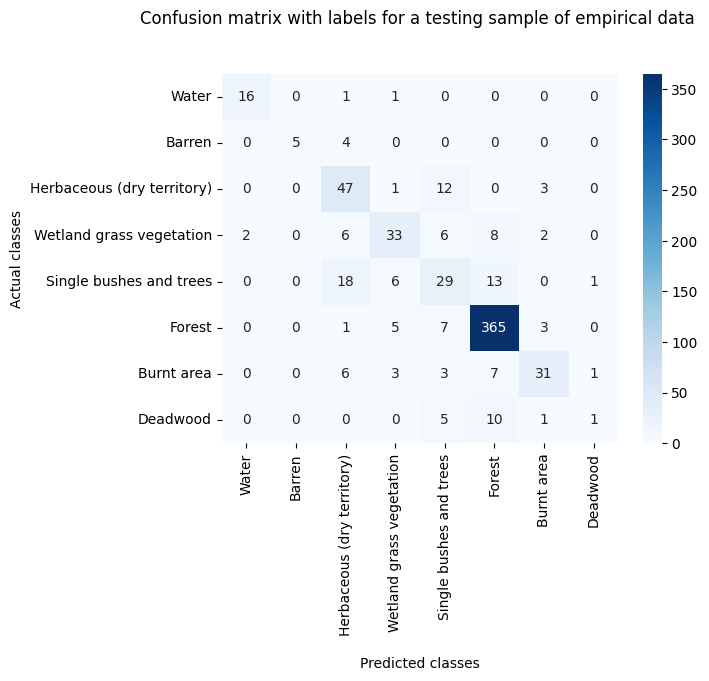

<Figure size 3000x3000 with 0 Axes>


 Iteration #3 

[0]	validation_0-mlogloss:1.93041	validation_1-mlogloss:1.94005
[1]	validation_0-mlogloss:1.80056	validation_1-mlogloss:1.82020
[2]	validation_0-mlogloss:1.69059	validation_1-mlogloss:1.72033
[3]	validation_0-mlogloss:1.59437	validation_1-mlogloss:1.63382
[4]	validation_0-mlogloss:1.50722	validation_1-mlogloss:1.55301
[5]	validation_0-mlogloss:1.42911	validation_1-mlogloss:1.48265
[6]	validation_0-mlogloss:1.35826	validation_1-mlogloss:1.41704
[7]	validation_0-mlogloss:1.29478	validation_1-mlogloss:1.35844
[8]	validation_0-mlogloss:1.23512	validation_1-mlogloss:1.30749
[9]	validation_0-mlogloss:1.18130	validation_1-mlogloss:1.25942
[10]	validation_0-mlogloss:1.13181	validation_1-mlogloss:1.21515
[11]	validation_0-mlogloss:1.08495	validation_1-mlogloss:1.17445
[12]	validation_0-mlogloss:1.04154	validation_1-mlogloss:1.13578
[13]	validation_0-mlogloss:1.00239	validation_1-mlogloss:1.10277
[14]	validation_0-mlogloss:0.96517	validation_1-mlogloss:1.07002
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


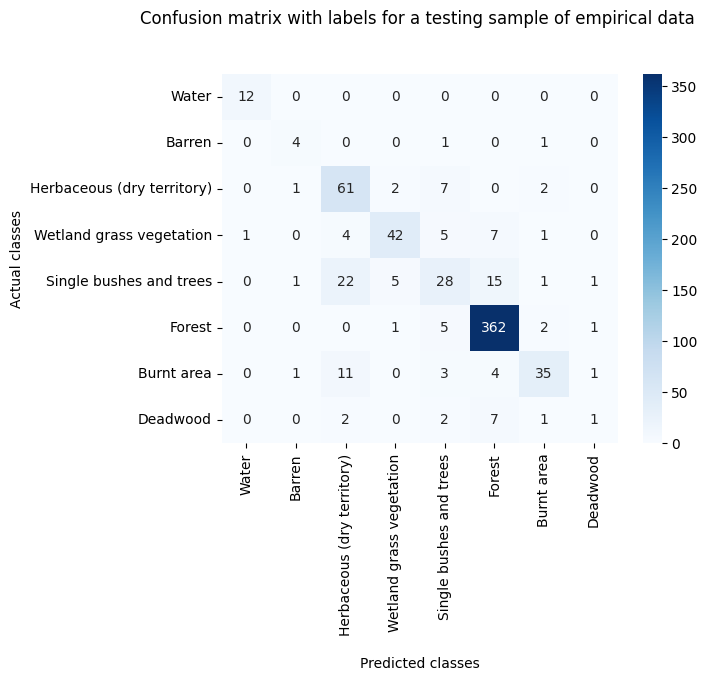

<Figure size 3000x3000 with 0 Axes>


 Iteration #4 

[0]	validation_0-mlogloss:1.92655	validation_1-mlogloss:1.93844
[1]	validation_0-mlogloss:1.79808	validation_1-mlogloss:1.81899
[2]	validation_0-mlogloss:1.68851	validation_1-mlogloss:1.71648
[3]	validation_0-mlogloss:1.59298	validation_1-mlogloss:1.62982
[4]	validation_0-mlogloss:1.50869	validation_1-mlogloss:1.55000
[5]	validation_0-mlogloss:1.43072	validation_1-mlogloss:1.47890
[6]	validation_0-mlogloss:1.36004	validation_1-mlogloss:1.41648
[7]	validation_0-mlogloss:1.29537	validation_1-mlogloss:1.35817
[8]	validation_0-mlogloss:1.23818	validation_1-mlogloss:1.30484
[9]	validation_0-mlogloss:1.18507	validation_1-mlogloss:1.25666
[10]	validation_0-mlogloss:1.13640	validation_1-mlogloss:1.21369
[11]	validation_0-mlogloss:1.09056	validation_1-mlogloss:1.17354
[12]	validation_0-mlogloss:1.04652	validation_1-mlogloss:1.13560
[13]	validation_0-mlogloss:1.00821	validation_1-mlogloss:1.10176
[14]	validation_0-mlogloss:0.97140	validation_1-mlogloss:1.06892
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


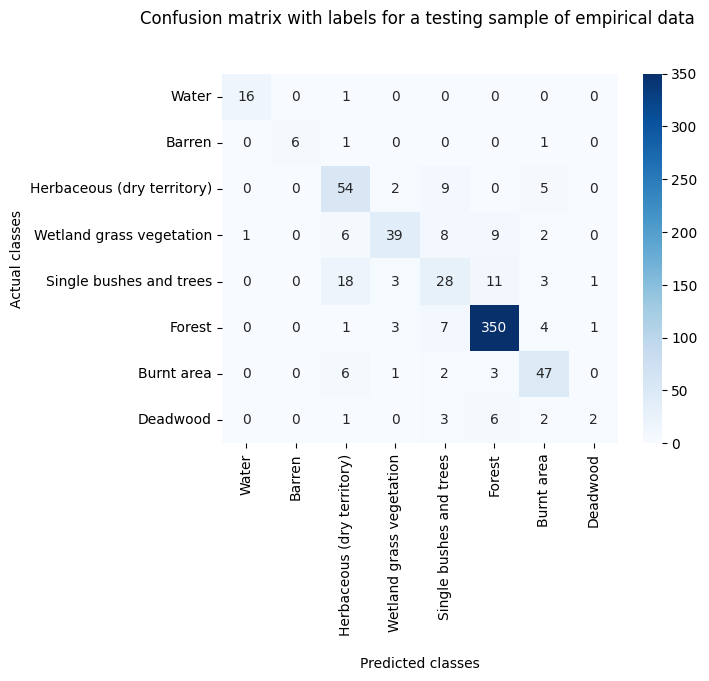

<Figure size 3000x3000 with 0 Axes>


 Iteration #5 

[0]	validation_0-mlogloss:1.92952	validation_1-mlogloss:1.93265
[1]	validation_0-mlogloss:1.80199	validation_1-mlogloss:1.81168
[2]	validation_0-mlogloss:1.69652	validation_1-mlogloss:1.71317
[3]	validation_0-mlogloss:1.60160	validation_1-mlogloss:1.62585
[4]	validation_0-mlogloss:1.51534	validation_1-mlogloss:1.54429
[5]	validation_0-mlogloss:1.43839	validation_1-mlogloss:1.47344
[6]	validation_0-mlogloss:1.36967	validation_1-mlogloss:1.40953
[7]	validation_0-mlogloss:1.30539	validation_1-mlogloss:1.34911
[8]	validation_0-mlogloss:1.24625	validation_1-mlogloss:1.29429
[9]	validation_0-mlogloss:1.19387	validation_1-mlogloss:1.24624
[10]	validation_0-mlogloss:1.14559	validation_1-mlogloss:1.20088
[11]	validation_0-mlogloss:1.10045	validation_1-mlogloss:1.15898
[12]	validation_0-mlogloss:1.05816	validation_1-mlogloss:1.11964
[13]	validation_0-mlogloss:1.01798	validation_1-mlogloss:1.08224
[14]	validation_0-mlogloss:0.98074	validation_1-mlogloss:1.04724
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


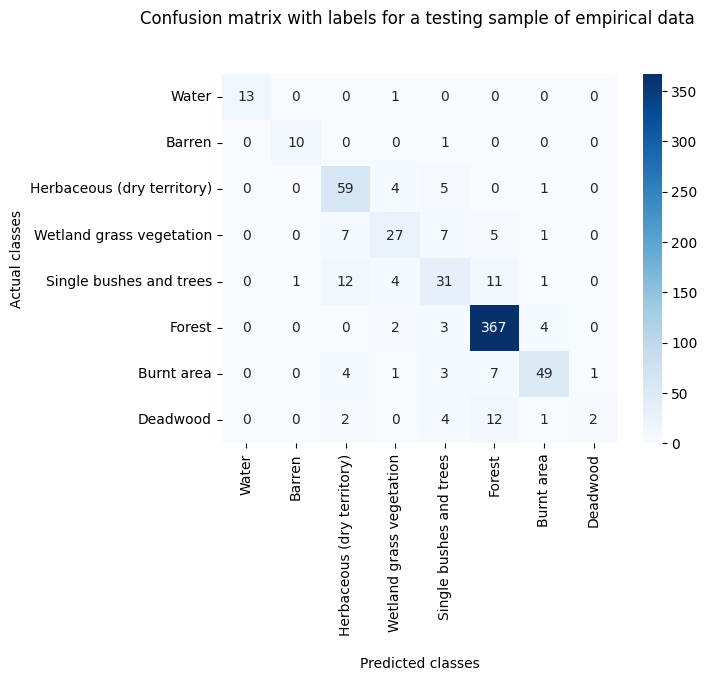

<Figure size 3000x3000 with 0 Axes>


 Iteration #6 

[0]	validation_0-mlogloss:1.93113	validation_1-mlogloss:1.93000
[1]	validation_0-mlogloss:1.80337	validation_1-mlogloss:1.80308
[2]	validation_0-mlogloss:1.69809	validation_1-mlogloss:1.69725
[3]	validation_0-mlogloss:1.60443	validation_1-mlogloss:1.60245
[4]	validation_0-mlogloss:1.52078	validation_1-mlogloss:1.51909
[5]	validation_0-mlogloss:1.44301	validation_1-mlogloss:1.44225
[6]	validation_0-mlogloss:1.37571	validation_1-mlogloss:1.37537
[7]	validation_0-mlogloss:1.31328	validation_1-mlogloss:1.31426
[8]	validation_0-mlogloss:1.25459	validation_1-mlogloss:1.25826
[9]	validation_0-mlogloss:1.20264	validation_1-mlogloss:1.20878
[10]	validation_0-mlogloss:1.15370	validation_1-mlogloss:1.16244
[11]	validation_0-mlogloss:1.10812	validation_1-mlogloss:1.11891
[12]	validation_0-mlogloss:1.06580	validation_1-mlogloss:1.07898
[13]	validation_0-mlogloss:1.02679	validation_1-mlogloss:1.04364
[14]	validation_0-mlogloss:0.98999	validation_1-mlogloss:1.00921
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


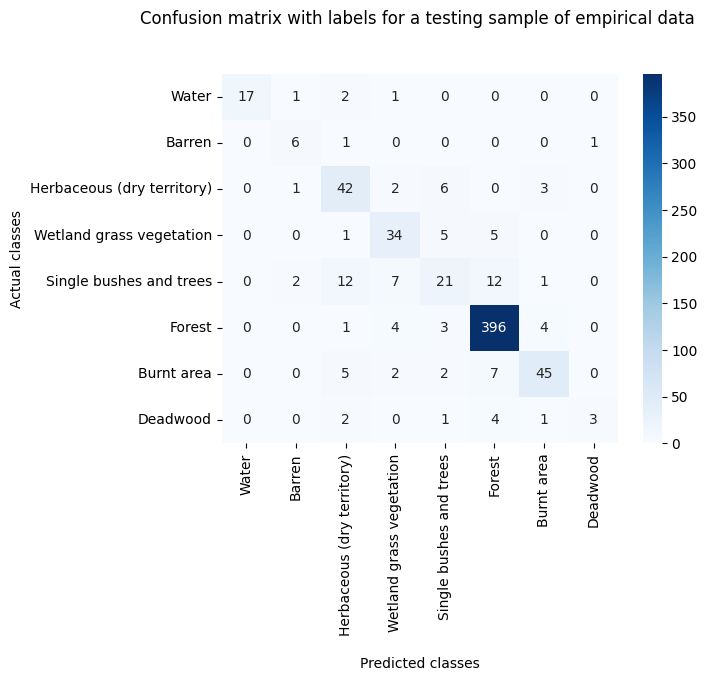

<Figure size 3000x3000 with 0 Axes>


 Iteration #7 

[0]	validation_0-mlogloss:1.92726	validation_1-mlogloss:1.93576
[1]	validation_0-mlogloss:1.79700	validation_1-mlogloss:1.81078
[2]	validation_0-mlogloss:1.69219	validation_1-mlogloss:1.71315
[3]	validation_0-mlogloss:1.59896	validation_1-mlogloss:1.62590
[4]	validation_0-mlogloss:1.51477	validation_1-mlogloss:1.54545
[5]	validation_0-mlogloss:1.43693	validation_1-mlogloss:1.47374
[6]	validation_0-mlogloss:1.36683	validation_1-mlogloss:1.40754
[7]	validation_0-mlogloss:1.30211	validation_1-mlogloss:1.34810
[8]	validation_0-mlogloss:1.24424	validation_1-mlogloss:1.29393
[9]	validation_0-mlogloss:1.19060	validation_1-mlogloss:1.24542
[10]	validation_0-mlogloss:1.14255	validation_1-mlogloss:1.20217
[11]	validation_0-mlogloss:1.09666	validation_1-mlogloss:1.15997
[12]	validation_0-mlogloss:1.05289	validation_1-mlogloss:1.12067
[13]	validation_0-mlogloss:1.01408	validation_1-mlogloss:1.08682
[14]	validation_0-mlogloss:0.97693	validation_1-mlogloss:1.05495
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


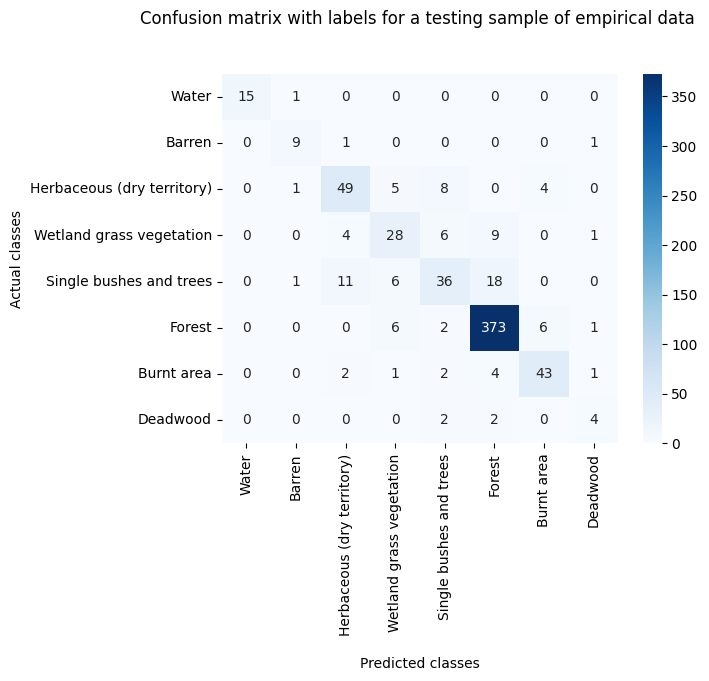

<Figure size 3000x3000 with 0 Axes>


 Iteration #8 

[0]	validation_0-mlogloss:1.92252	validation_1-mlogloss:1.93796
[1]	validation_0-mlogloss:1.79522	validation_1-mlogloss:1.81858
[2]	validation_0-mlogloss:1.69124	validation_1-mlogloss:1.71995
[3]	validation_0-mlogloss:1.59521	validation_1-mlogloss:1.63014
[4]	validation_0-mlogloss:1.50738	validation_1-mlogloss:1.55097
[5]	validation_0-mlogloss:1.42845	validation_1-mlogloss:1.47794
[6]	validation_0-mlogloss:1.35662	validation_1-mlogloss:1.41337
[7]	validation_0-mlogloss:1.29321	validation_1-mlogloss:1.35741
[8]	validation_0-mlogloss:1.23507	validation_1-mlogloss:1.30449
[9]	validation_0-mlogloss:1.18125	validation_1-mlogloss:1.25479
[10]	validation_0-mlogloss:1.13196	validation_1-mlogloss:1.21181
[11]	validation_0-mlogloss:1.08616	validation_1-mlogloss:1.17211
[12]	validation_0-mlogloss:1.04274	validation_1-mlogloss:1.13411
[13]	validation_0-mlogloss:1.00428	validation_1-mlogloss:1.09997
[14]	validation_0-mlogloss:0.96719	validation_1-mlogloss:1.06756
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


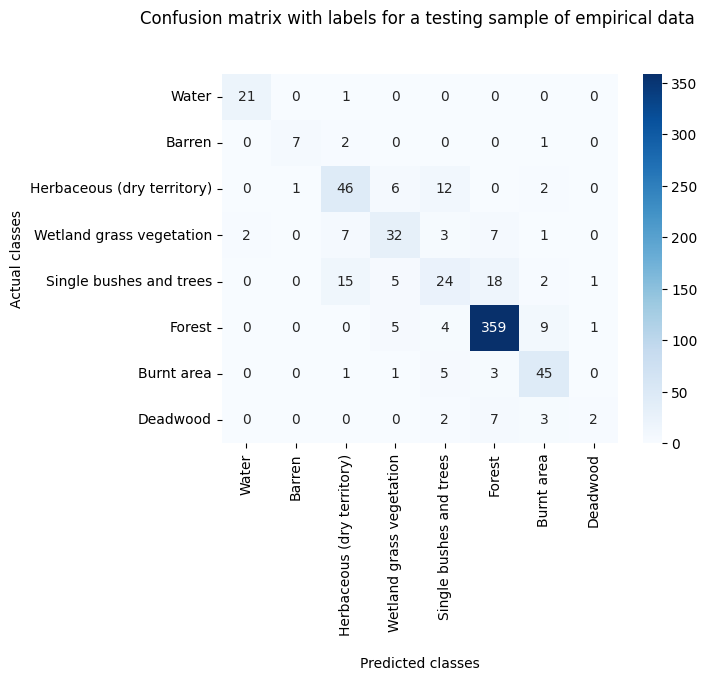

<Figure size 3000x3000 with 0 Axes>


 Iteration #9 

[0]	validation_0-mlogloss:1.92634	validation_1-mlogloss:1.94061
[1]	validation_0-mlogloss:1.79833	validation_1-mlogloss:1.82035
[2]	validation_0-mlogloss:1.68854	validation_1-mlogloss:1.71962
[3]	validation_0-mlogloss:1.59076	validation_1-mlogloss:1.62987
[4]	validation_0-mlogloss:1.50679	validation_1-mlogloss:1.55173
[5]	validation_0-mlogloss:1.42818	validation_1-mlogloss:1.47744
[6]	validation_0-mlogloss:1.36111	validation_1-mlogloss:1.41488
[7]	validation_0-mlogloss:1.29730	validation_1-mlogloss:1.35643
[8]	validation_0-mlogloss:1.23926	validation_1-mlogloss:1.30188
[9]	validation_0-mlogloss:1.18599	validation_1-mlogloss:1.25574
[10]	validation_0-mlogloss:1.13674	validation_1-mlogloss:1.21069
[11]	validation_0-mlogloss:1.08967	validation_1-mlogloss:1.16934
[12]	validation_0-mlogloss:1.04668	validation_1-mlogloss:1.13057
[13]	validation_0-mlogloss:1.00709	validation_1-mlogloss:1.09652
[14]	validation_0-mlogloss:0.97033	validation_1-mlogloss:1.06365
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


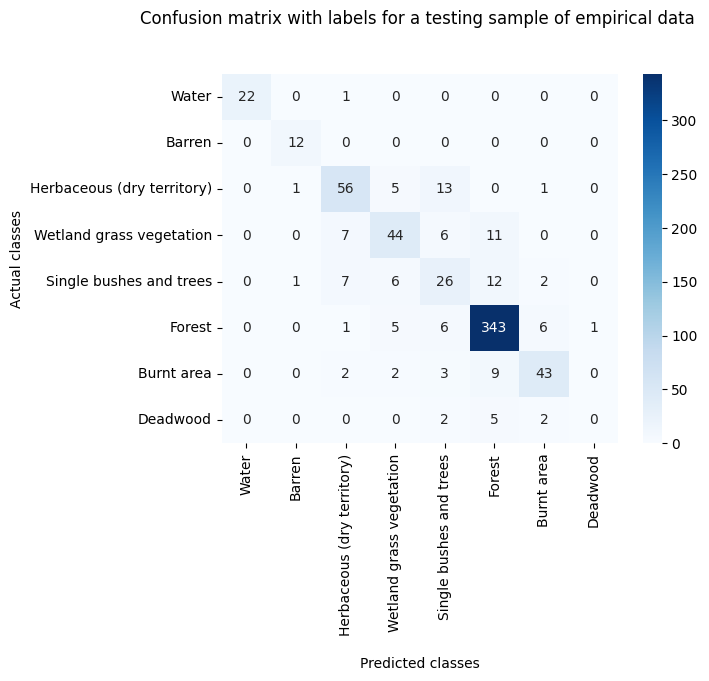

<Figure size 3000x3000 with 0 Axes>


 Iteration #10 

[0]	validation_0-mlogloss:1.92932	validation_1-mlogloss:1.93408
[1]	validation_0-mlogloss:1.80282	validation_1-mlogloss:1.81255
[2]	validation_0-mlogloss:1.69398	validation_1-mlogloss:1.71072
[3]	validation_0-mlogloss:1.59504	validation_1-mlogloss:1.61740
[4]	validation_0-mlogloss:1.51121	validation_1-mlogloss:1.53630
[5]	validation_0-mlogloss:1.43443	validation_1-mlogloss:1.46146
[6]	validation_0-mlogloss:1.36748	validation_1-mlogloss:1.39700
[7]	validation_0-mlogloss:1.30354	validation_1-mlogloss:1.33690
[8]	validation_0-mlogloss:1.24475	validation_1-mlogloss:1.28287
[9]	validation_0-mlogloss:1.19135	validation_1-mlogloss:1.23395
[10]	validation_0-mlogloss:1.14373	validation_1-mlogloss:1.19096
[11]	validation_0-mlogloss:1.09800	validation_1-mlogloss:1.15042
[12]	validation_0-mlogloss:1.05573	validation_1-mlogloss:1.11137
[13]	validation_0-mlogloss:1.01686	validation_1-mlogloss:1.07596
[14]	validation_0-mlogloss:0.98016	validation_1-mlogloss:1.04285
[15]	validation_0

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


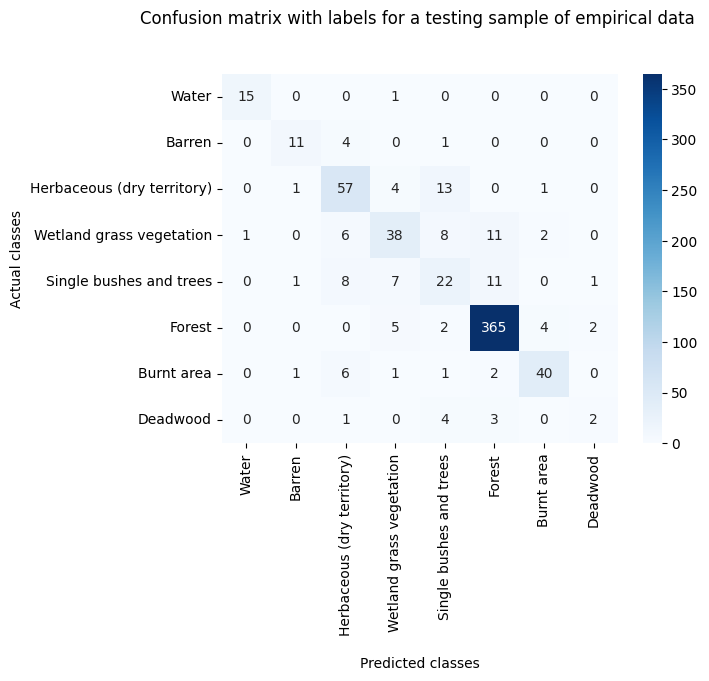

<Figure size 3000x3000 with 0 Axes>

In [13]:
# Create 10 traning iteration

for i in range (10):
    print("\n", f"Iteration #{i+1}", "\n")
    # Generate test and training samples
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Implementation of the scikit-learn API for XGBoost regression
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", colsample_bytree=p1, gamma=p2, learning_rate=p3, 
                          max_depth=p4, n_estimators=p5, subsample=p6, eval_metric=['mlogloss'])
    
    # Fitting the model 
    xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
    # learning dynamics
    y_pred = xgb_model.predict(X_test, ntree_limit=xgb_model.best_ntree_limit)
    
    print('Model XGboost report for testing data:') 
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

    ax.set_title('Confusion matrix with labels for a testing sample of empirical data \n\n');
    ax.set_xlabel('\nPredicted classes')
    ax.set_ylabel('Actual classes');

    # Name`s class list
    ax.xaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])
    ax.yaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])

    ## Display the visualization of the Confusion Matrix
    plt.xticks(rotation=90) 
    plt.yticks(rotation=0) 
    plt.figure(figsize =(30, 30))
    plt.show()

# Create and estimation of a final XGBoost model

[0]	validation_0-mlogloss:1.92661
[1]	validation_0-mlogloss:1.79912
[2]	validation_0-mlogloss:1.68903
[3]	validation_0-mlogloss:1.59354
[4]	validation_0-mlogloss:1.51213
[5]	validation_0-mlogloss:1.43659
[6]	validation_0-mlogloss:1.36808
[7]	validation_0-mlogloss:1.30478
[8]	validation_0-mlogloss:1.24704
[9]	validation_0-mlogloss:1.19173
[10]	validation_0-mlogloss:1.14339
[11]	validation_0-mlogloss:1.09919
[12]	validation_0-mlogloss:1.05550
[13]	validation_0-mlogloss:1.01452
[14]	validation_0-mlogloss:0.97781
[15]	validation_0-mlogloss:0.94226
[16]	validation_0-mlogloss:0.90975
[17]	validation_0-mlogloss:0.87952
[18]	validation_0-mlogloss:0.85152
[19]	validation_0-mlogloss:0.82418
[20]	validation_0-mlogloss:0.79838
[21]	validation_0-mlogloss:0.77479
[22]	validation_0-mlogloss:0.75141
[23]	validation_0-mlogloss:0.72888
[24]	validation_0-mlogloss:0.70900
[25]	validation_0-mlogloss:0.68825
[26]	validation_0-mlogloss:0.66970
[27]	validation_0-mlogloss:0.65170
[28]	validation_0-mlogloss:0.6

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.85      0.85      0.85        34
           2       0.83      0.93      0.88       242
           3       0.89      0.84      0.86       182
           4       0.84      0.68      0.75       205
           5       0.95      0.98      0.97      1266
           6       0.90      0.88      0.89       184
           7       1.00      0.60      0.75        42

    accuracy                           0.92      2210
   macro avg       0.91      0.84      0.86      2210
weighted avg       0.92      0.92      0.92      2210



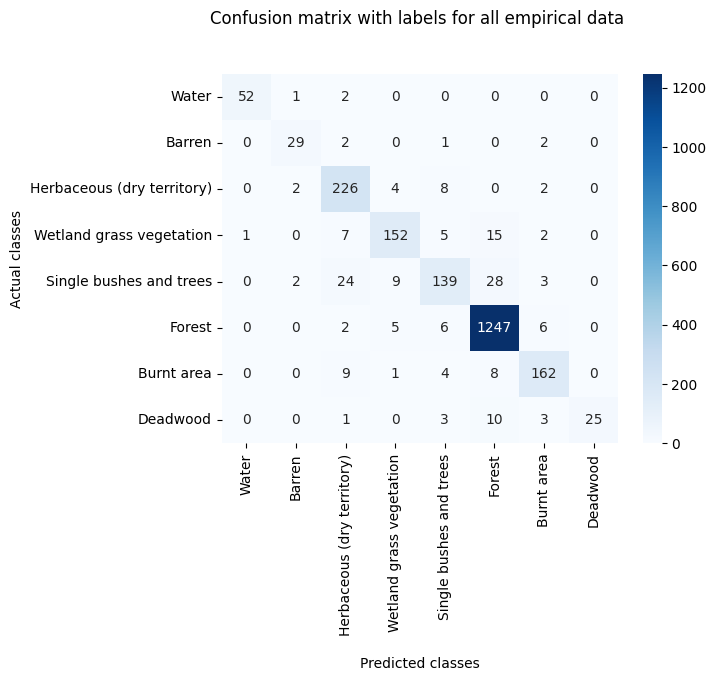

<Figure size 3000x3000 with 0 Axes>

In [14]:
# Fitting the model 
xgb_model.fit(X, y, eval_set=[(X, y)])
# learning dynamics
y_pred = xgb_model.predict(X, ntree_limit=xgb_model.best_ntree_limit)
    
print('\nModel XGboost report for all obs.:') 
print(classification_report(y, y_pred))
    
# Create confusion matrix
cf_matrix = confusion_matrix(y, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

ax.set_title('Confusion matrix with labels for all empirical data \n\n');
ax.set_xlabel('\nPredicted classes')
ax.set_ylabel('Actual classes');

# Name`s class list
ax.xaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])
ax.yaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])

## Display the visualization of the Confusion Matrix
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.figure(figsize =(30, 30))
plt.show()

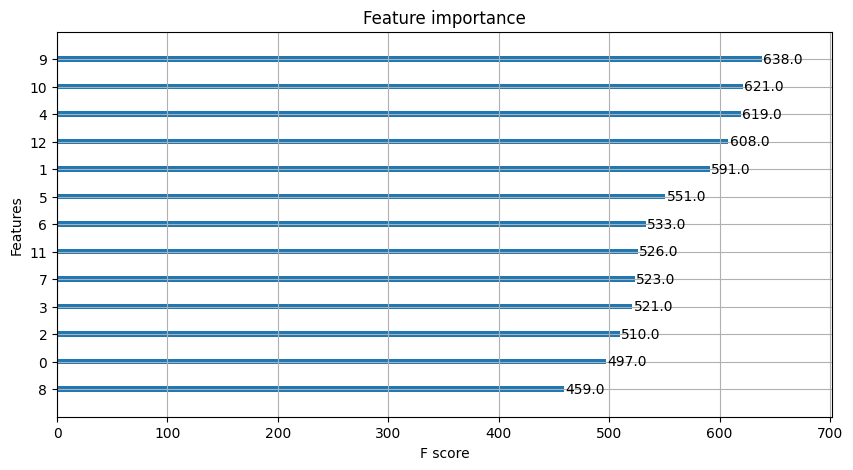

In [16]:
# Importance is calculated as: ”weight” is the number of times a feature appears in a trees
xgb.plot_importance(xgb_model, importance_type='weight')
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

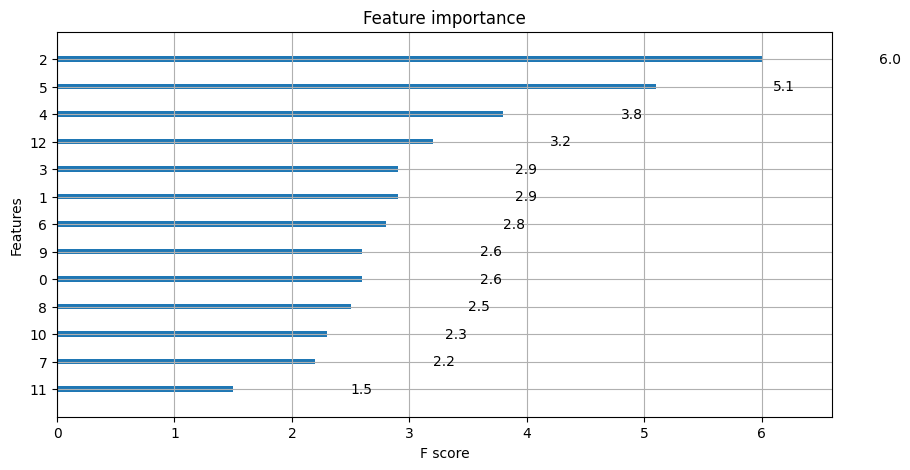

In [17]:
# Importance is calculated as: ”gain” is the average gain of splits which use the feature
# Get the booster from the xgbmodel
booster = xgb_model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="gain")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key], 1)

# provide the importance dictionary to the plotting function
ax = xgb.plot_importance(importance, importance_type='gain', show_values=True)
plt.rcParams['figure.figsize'] = [5, 6]

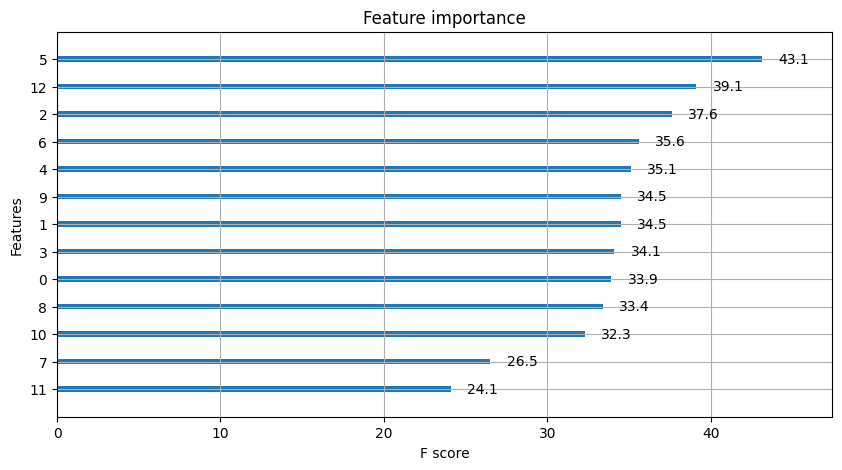

In [19]:
# Importance is calculated as: "cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split
# Get the booster from the xgbmodel
booster = xgb_model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="cover")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key],1)

# provide the importance dictionary to the plotting function
ax = xgb.plot_importance(importance, importance_type='cover', show_values=True)
plt.rcParams['figure.figsize'] = [10, 5]

# SHAP method

In [20]:
# Load SHAP`s library
import shap

In [21]:
# Сreate an уxplainer object
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


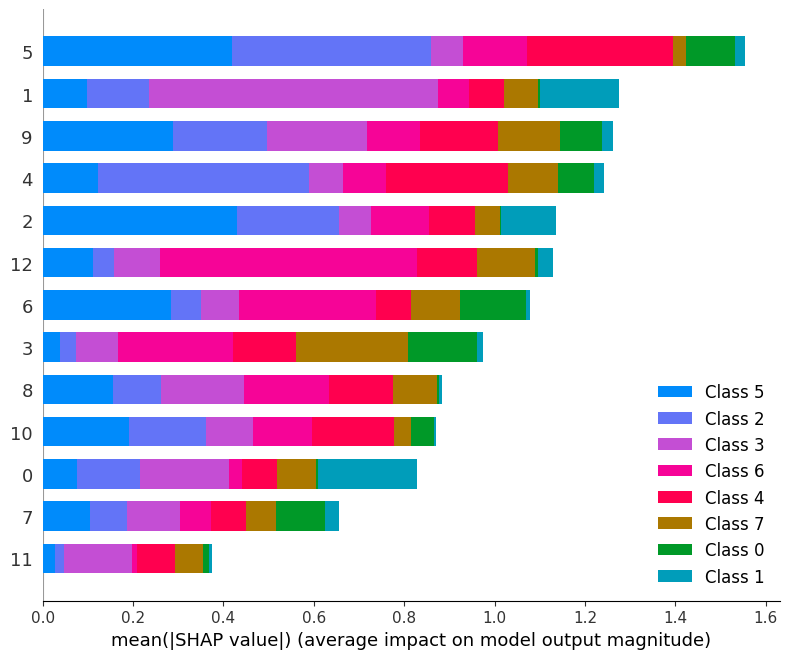

In [22]:
# Mean absolute value of the SHAP values for each feature 
shap.summary_plot(shap_values, X, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


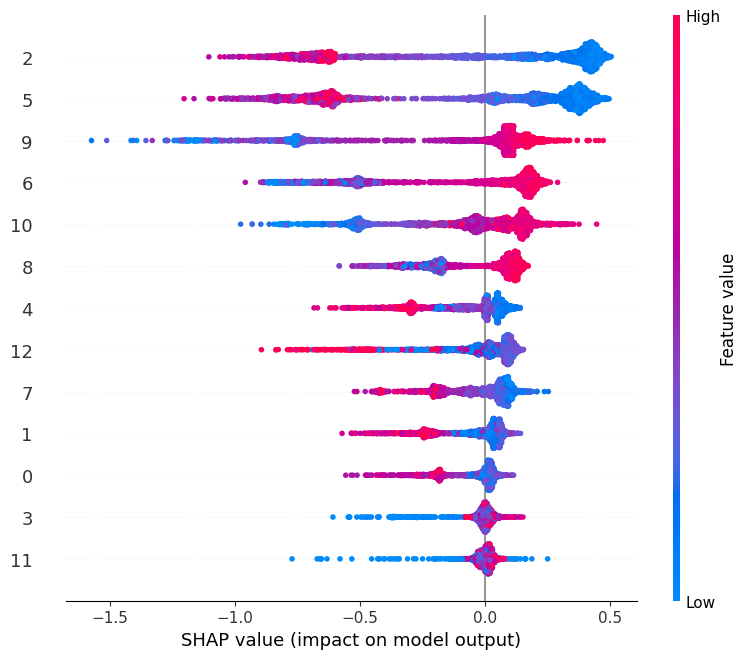

In [23]:
# Graph that summarises the effects of individual features (shap.values[feature])
shap.summary_plot(shap_values[5], X)

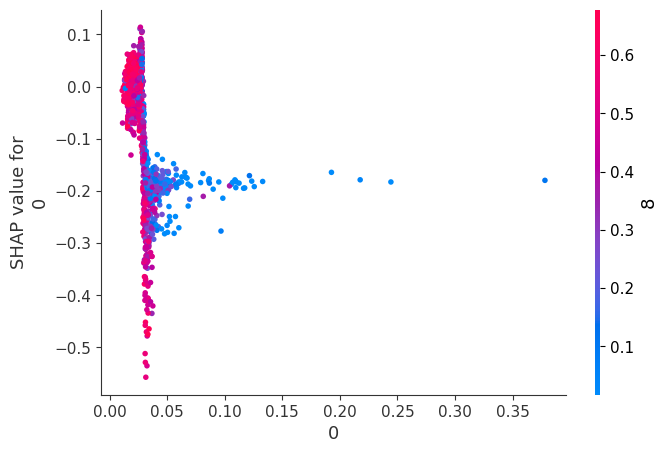

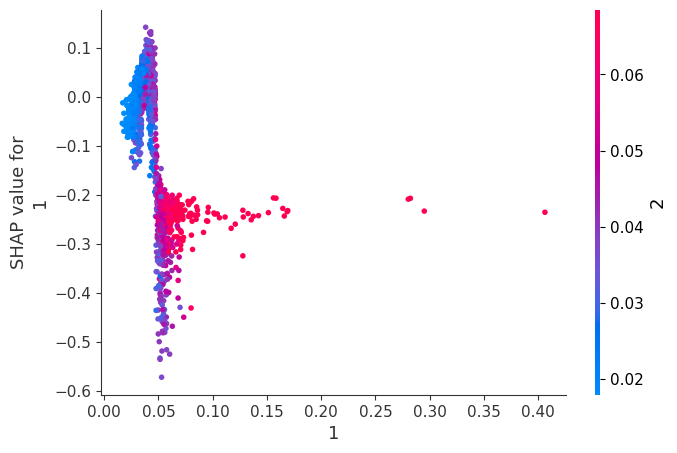

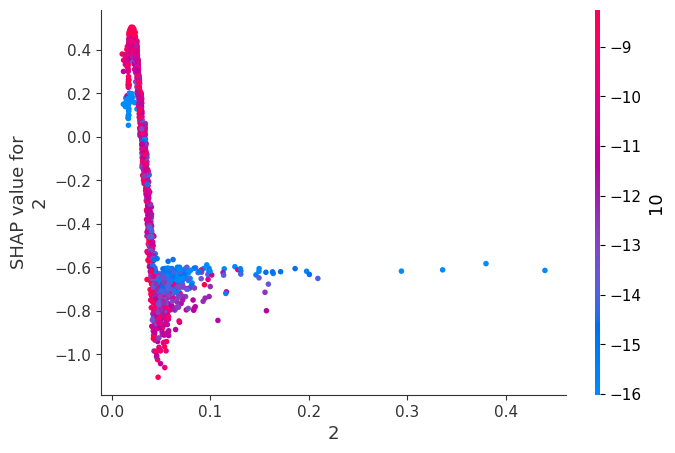

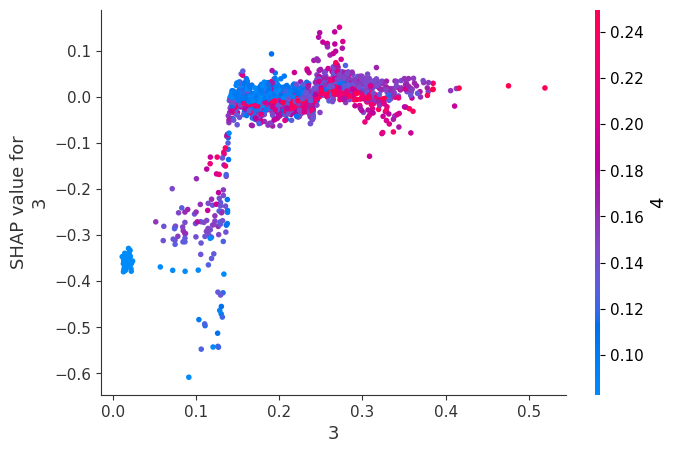

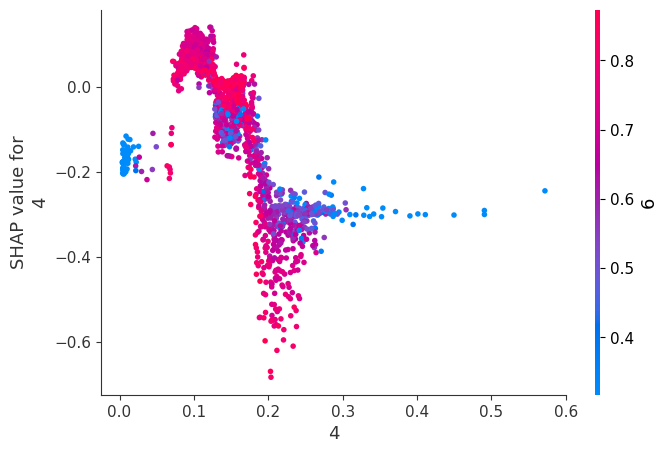

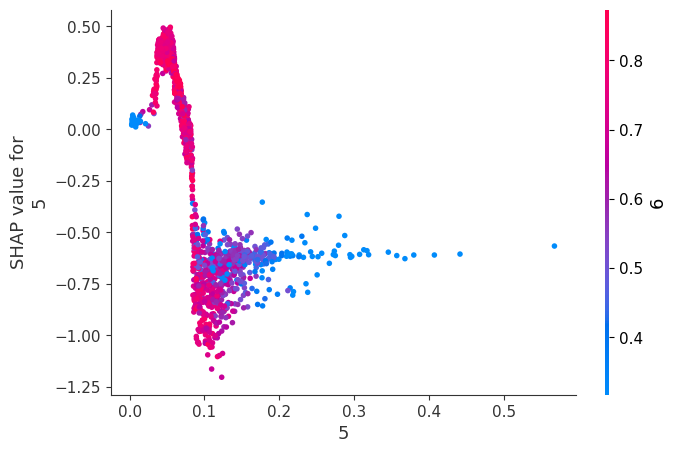

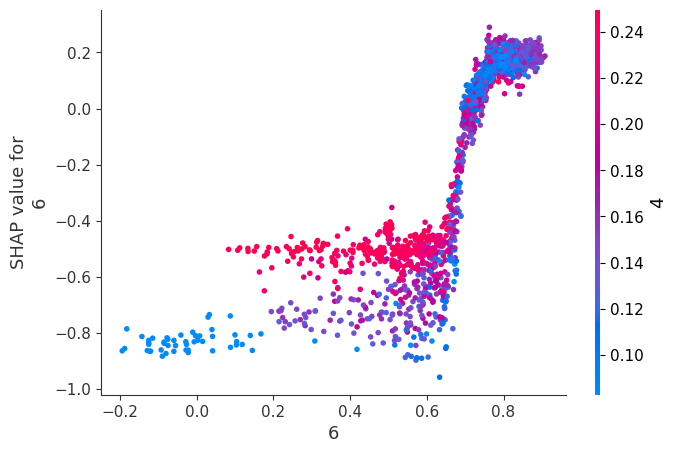

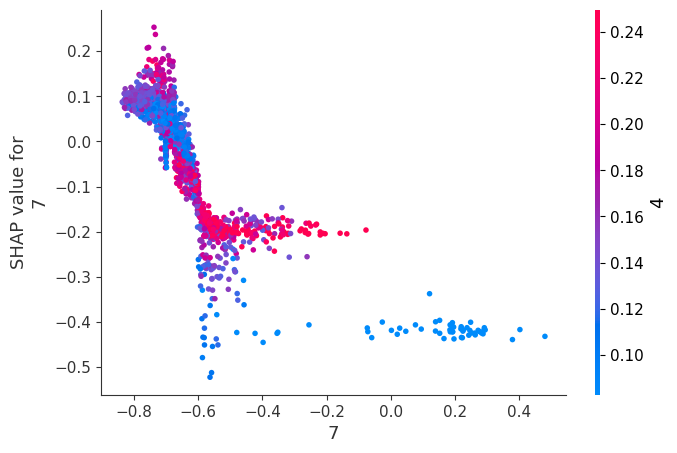

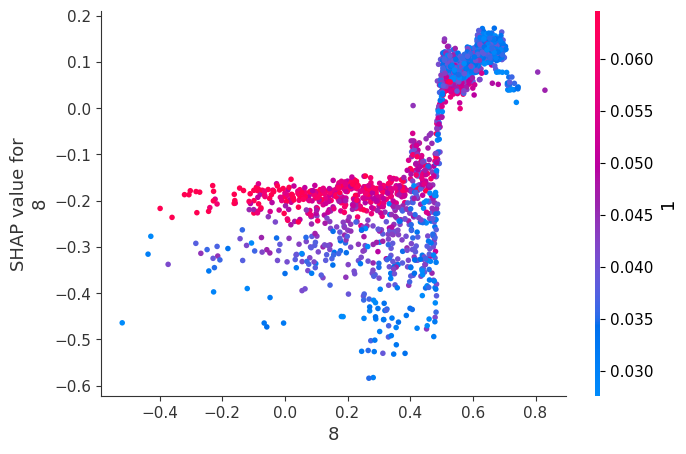

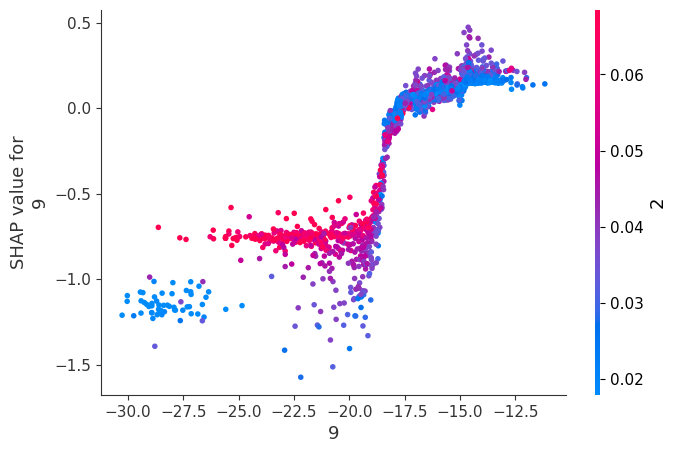

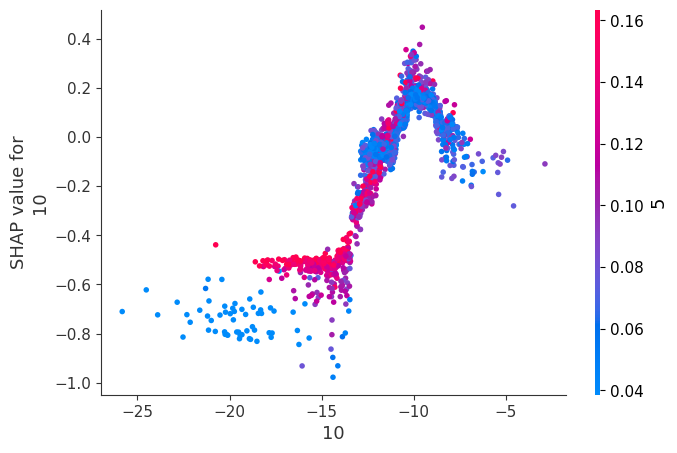

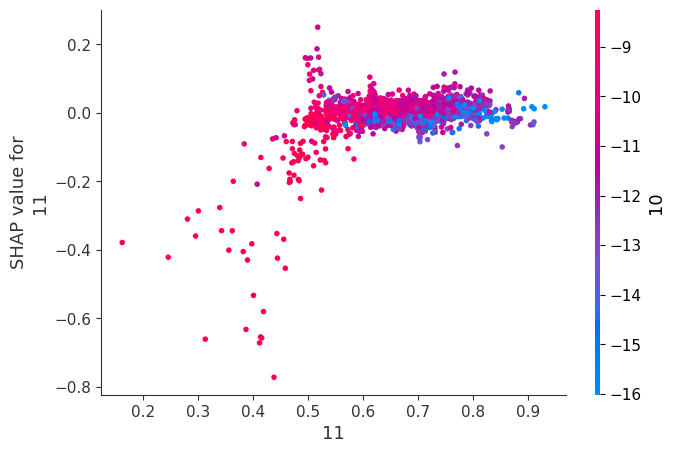

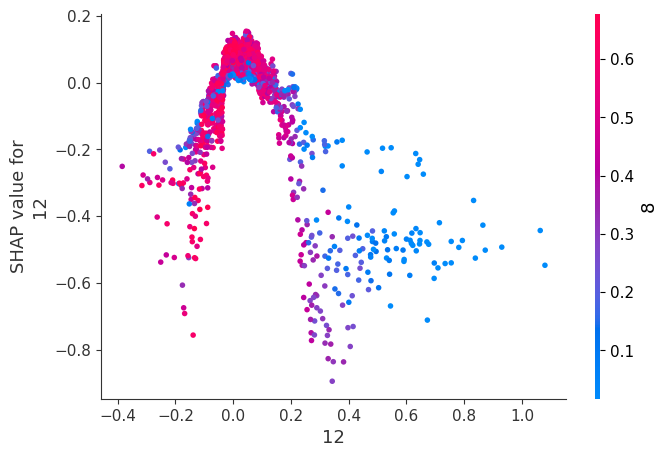

In [24]:
# Create a dependence scatter plot to show the effect of a single feature across the whole dataset
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[5], X, color=shap_values)

# Save XGBoost model

In [25]:
# Save to JSON
xgb_model.save_model("../Final_results/xgb_model_Sentinel_classific_2020.json")
# Save to text format
xgb_model.save_model("../Final_results/xgb_model_Sentinel_classific_2020.txt")

# Classification of all interest territory

In [26]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

img_as_array = img.reshape(new_shape)
new_shape = ""
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

Reshaped from (5161, 9008, 13) to (46490288, 13)


In [27]:
# Now predict for each pixel
class_prediction = xgb_model.predict(img_as_array)
img_as_array = ""

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

In [ ]:
# Visualize

# First setup a 3-2-1 composite
def color_stretch(image, index, minmax=(-20, 1)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img321 = color_stretch(img, [3, 2, 1], (0, 1))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 255, 255)),  # Water
    (1, (0, 0, 0, 255)),  # Barren
    (2, (0, 100, 100, 255)),  # Herbaceous (dry teritory)
    (3, (0, 255, 255, 255)),  # Wetland grass vegetation
    (4, (160, 82, 45, 255)), # Single bushes and trees
    (5, (0, 255, 0, 255)),  # Forest
    (6, (255, 0, 0, 255)),  # Burnt area
    (7, (0, 0, 100, 255)),  # Deadwood    
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img321)

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()

# Save classification raster

In [28]:
import rasterio

In [29]:
# Save classification raster
from affine import Affine
af_transf = Affine.from_gdal(*GT_input)

with rasterio.open(
    '../Final_results/classif_map_2020.tif',
    'w',
    driver='GTiff',
    height=class_prediction.shape[0],
    width=class_prediction.shape[1],
    count=1,
    dtype=np.float32,
    transform=af_transf
) as dest_file:
    dest_file.write(class_prediction, 1)
dest_file.close()